**Making the notebook flexible between different environments (google cloab and Kaggle)**

In [1]:
import os
import sys

# Detect the environment
def detect_environment():
    if 'google.colab' in sys.modules:
        return "Google Colab"
    elif os.path.exists('/kaggle/working'):
        return "Kaggle"
    else:
        return "Unknown"

# Adapt path based on environment
def adapt_path(path):
    env = detect_environment()

    if env == "Google Colab":
        base_path = "/content"
    elif env == "Kaggle":
        base_path = "/kaggle/working"
    else:
        raise EnvironmentError("Unsupported environment")

    # If the path starts with the base path of the other environment, remove it
    if env == "Google Colab" and path.startswith("/kaggle/working"):
        path = path.replace("/kaggle/working", "/content", 1)
    elif env == "Kaggle" and path.startswith("/content"):
        path = path.replace("/content", "/kaggle/working", 1)

    # If the path already starts with the base path of the current environment, return the path as is
    if path.startswith(base_path):
        return path
    else:
        # If the path is relative, make it absolute by joining with the base path
        return os.path.join(base_path, path.lstrip("/"))

# Example usage
base_path = adapt_path("")
print(base_path)

/kaggle/working/


**Delete all Folders that save before**

In [2]:
import shutil
import os

# Path to the main directory where files are stored
root_dir = "/content/"

# Remove all files and folders in the root directory except system folders
for item in os.listdir(root_dir):
    item_path = os.path.join(root_dir, item)
    if item not in ["sample_data"]:  # Exclude system default folders if needed
        try:
            if os.path.isfile(item_path) or os.path.islink(item_path):
                os.unlink(item_path)  # Remove files and links
            elif os.path.isdir(item_path):
                shutil.rmtree(item_path)  # Remove directories
        except Exception as e:
            print(f"Failed to delete {item}: {e}")

print("All files and folders deleted!")

All files and folders deleted!


**Cleaning up TensorFlow resources to free memory**

In [3]:
import tensorflow as tf
import gc

def clear_tf_memory():
    """Clears TensorFlow-related memory while preserving imports and functions"""
    try:
        # Clear the Keras session (removes models, layers, etc.)
        tf.keras.backend.clear_session()

        # Collect TensorFlow objects that are still in scope
        for var in list(globals().keys()):
            if var.startswith('_'):
                continue
            obj = globals()[var]
            if isinstance(obj, (tf.keras.Model, tf.keras.layers.Layer,
                               tf.Variable, tf.Tensor, tf.keras.optimizers.Optimizer)):
                del globals()[var]

        # Clear any remaining TensorFlow graphs
        tf.compat.v1.reset_default_graph()

        # Force garbage collection
        gc.collect()

        #print("Successfully cleared TensorFlow memory while preserving other objects")

    except Exception as e:
        print(f"Error during memory clearing: {str(e)}")

# Usage:
clear_tf_memory()
clear_tf_memory()
clear_tf_memory()
clear_tf_memory()

2025-05-30 14:23:56.391374: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748615036.583178      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748615036.640229      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**Read Brain MRI Dataset**

In [4]:
import gdown
import zipfile
import os

def download_and_extract(file_id, zip_file_name, extract_dir):
    try:
        url = f"https://drive.google.com/uc?id={file_id}"
        print(f"Trying to download from: {url}")

        gdown.download(url, zip_file_name, quiet=True)

        if zipfile.is_zipfile(zip_file_name):
            with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
                zip_ref.extractall(extract_dir)
            print(f"File extracted successfully to '{extract_dir}'.")
            return True
        else:
            print("Downloaded file is not a valid ZIP.")
            return False
    except Exception:
        # Suppress gdown or zip-related errors
        return False
    finally:
        # Clean up corrupted file if it exists
        if os.path.exists(zip_file_name) and not zipfile.is_zipfile(zip_file_name):
            os.remove(zip_file_name)

# Primary and backup file IDs
primary_file_id = "1xeDA0XHfm317gyCtyhf7Vq2RZxpmcDAN"
backup_file_id = "1WezujZUWHlPpL6xhpwwCKcypxE096XsQ"

# Download attempt
success = download_and_extract(primary_file_id, "Brain MRI Dataset.zip", "Brain MRI Dataset")

# Try backup if primary fails
if not success:
    print("Primary download failed. Attempting download from backup link...")
    success = download_and_extract(backup_file_id, "Brain MRI Dataset.zip", "Brain MRI Dataset")

if not success:
    print("Both primary and backup downloads failed.")


Trying to download from: https://drive.google.com/uc?id=1xeDA0XHfm317gyCtyhf7Vq2RZxpmcDAN
File extracted successfully to 'Brain MRI Dataset'.


**Train-Validarion-Test Split**

In [5]:
import os
import shutil
import random

def split_dataset(root_dir, output_dir, seed=42):
    random.seed(seed)

    # List all patient folders
    patient_dirs = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    patient_dirs.sort()  # Ensure deterministic order before shuffle
    random.shuffle(patient_dirs)

    assert len(patient_dirs) == 110, f"Expected 110 patients, found {len(patient_dirs)}"

    # Define exact counts
    train_count = 77
    val_count = 16
    test_count = 17

    train_patients = patient_dirs[:train_count]
    val_patients = patient_dirs[train_count:train_count + val_count]
    test_patients = patient_dirs[train_count + val_count:]

    print(f"Total: {len(patient_dirs)} patients")
    print(f"Train: {len(train_patients)}, Val: {len(val_patients)}, Test: {len(test_patients)}")

    # Function to copy patient folders and log IDs
    def copy_split(patients, split_name):
        split_dir = os.path.join(output_dir, split_name)
        os.makedirs(split_dir, exist_ok=True)
        for patient in patients:
            src = os.path.join(root_dir, patient)
            dst = os.path.join(split_dir, patient)
            if os.path.exists(dst):
                shutil.rmtree(dst)  # Remove existing folder to avoid error
            shutil.copytree(src, dst)
        # Log patient IDs
        with open(os.path.join(output_dir, f"{split_name}_ids.txt"), 'w') as f:
            for pid in patients:
                f.write(f"{pid}\n")

    copy_split(train_patients, "train")
    copy_split(val_patients, "val")
    copy_split(test_patients, "test")

# Example usage
original_dataset_dir = "Brain MRI Dataset/Brain MRI"  # Adjust if using absolute path
output_split_dir = "Brain MRI Split"

split_dataset(original_dataset_dir, output_split_dir)


Total: 110 patients
Train: 77, Val: 16, Test: 17


**Data Augmentation**

In [6]:
import os
import cv2
import albumentations as A
import numpy as np
import random
from tqdm import tqdm

# Function to get the augmentations with seed control
def get_aug(seed):
    # Set the random seed manually to control reproducibility
    random.seed(seed)
    np.random.seed(seed)

    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.2),
        A.RandomRotate90(p=0.5),
        A.ElasticTransform(p=0.2),
        A.GridDistortion(p=0.2),
        A.RandomBrightnessContrast(p=0.3),
        A.GaussianBlur(p=0.1),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5)
    ])

def augment_dataset_recursive(train_dir, output_dir, num_augmented=3, seed=42):
    # Set global random seed
    random.seed(seed)
    np.random.seed(seed)

    for root, _, files in os.walk(train_dir):
        for file in files:
            if file.lower().endswith(".tif") and not file.lower().endswith("_mask.tif"):
                image_path = os.path.join(root, file)
                mask_path = image_path.replace(".tif", "_mask.tif")

                if not os.path.exists(mask_path):
                    print(f"Mask not found for {image_path}, skipping.")
                    continue

                image = cv2.imread(image_path)
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

                if image is None or mask is None:
                    print(f"Error reading {image_path} or its mask.")
                    continue

                rel_dir = os.path.relpath(root, train_dir)
                save_dir = os.path.join(output_dir, rel_dir)
                os.makedirs(save_dir, exist_ok=True)

                base_name = os.path.splitext(file)[0]
                cv2.imwrite(os.path.join(save_dir, f"{base_name}.tif"), image)
                cv2.imwrite(os.path.join(save_dir, f"{base_name}_mask.tif"), mask)

                count = 0
                max_attempts = num_augmented * 5
                attempts = 0

                while count < num_augmented and attempts < max_attempts:
                    # Set a unique seed for each augmentation
                    aug_seed = hash((file, count, seed)) % (2**32)
                    aug = get_aug(aug_seed)

                    augmented = aug(image=image, mask=mask)
                    aug_img = augmented['image']
                    aug_mask = augmented['mask']

                    if np.array_equal(aug_img, image) and np.array_equal(aug_mask, mask):
                        attempts += 1
                        continue

                    aug_name = f"{base_name}_aug{count}"
                    cv2.imwrite(os.path.join(save_dir, f"{aug_name}.tif"), aug_img)
                    cv2.imwrite(os.path.join(save_dir, f"{aug_name}_mask.tif"), aug_mask)
                    count += 1
                    attempts += 1

    print("Augmentation completed.")

# Example usage
train_folder = "Brain MRI Split/train"
augmented_output = "Brain MRI Split/train_augmented"
augment_dataset_recursive(train_folder, augmented_output, num_augmented=1, seed=123)

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Augmentation completed.


**Main Architecture (Based on the paper)**

Loading training data...
Loading validation data...
Loading test data...
Training samples: 5438
Validation samples: 621
Test samples: 589
Building UNet-VGG16 model...


I0000 00:00:1748615139.665856      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 256, 256, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 128, 128, 64)   │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 128, 128, 128)  │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 128, 128, 128)  │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 64, 64, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 64, 64, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 64, 64, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 64, 64, 256)    │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 32, 32, 256)    │              0 │ block3_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 32, 32, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 32, 32, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 32, 32, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool               │ (None, 16, 16, 512)    │              0 │ block4_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv1 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block4_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv2 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block5_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv3 (Conv2D)

 Total params: 28,025,537 (106.91 MB)

 Trainable params: 13,310,849 (50.78 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Training model...
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1748615150.560424      93 service.cc:148] XLA service 0x7c68a0021470 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748615150.561561      93 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748615151.311706      93 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/680 ━━━━━━━━━━━━━━━━━━━━ 5:01:19 27s/step - accuracy: 0.2198 - dice_coefficient: 0.0202 - iou_score: 0.0102 - loss: 0.9798

I0000 00:00:1748615170.928727      93 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


555/680 ━━━━━━━━━━━━━━━━━━━━ 21s 173ms/step - accuracy: 0.9349 - dice_coefficient: 0.4287 - iou_score: 0.3125 - loss: 0.5713

E0000 00:00:1748615269.012633      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748615269.247741      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748615269.872494      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748615270.131138      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748615272.977838      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.9436 - dice_coefficient: 0.4473 - iou_score: 0.3289 - loss: 0.5527

E0000 00:00:1748615316.387872      93 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748615316.622635      93 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748615317.186895      93 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748615317.444591      93 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.



Epoch 1: val_dice_coefficient improved from -inf to 0.54598, saving model to models/unet_vgg16_best.keras
680/680 ━━━━━━━━━━━━━━━━━━━━ 177s 221ms/step - accuracy: 0.9436 - dice_coefficient: 0.4475 - iou_score: 0.3290 - loss: 0.5525 - val_accuracy: 0.9944 - val_dice_coefficient: 0.5460 - val_iou_score: 0.4388 - val_loss: 0.4533 - learning_rate: 1.0000e-04
Epoch 2/100
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.9940 - dice_coefficient: 0.6261 - iou_score: 0.4986 - loss: 0.3739
Epoch 2: val_dice_coefficient improved from 0.54598 to 0.57231, saving model to models/unet_vgg16_best.keras
680/680 ━━━━━━━━━━━━━━━━━━━━ 125s 184ms/step - accuracy: 0.9940 - dice_coefficient: 0.6262 - iou_score: 0.4986 - loss: 0.3738 - val_accuracy: 0.9956 - val_dice_coefficient: 0.5723 - val_iou_score: 0.4881 - val_loss: 0.4249 - learning_rate: 1.0000e-04
Epoch 3/100
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9948 - dice_coefficient: 0.6830 - iou_score: 0.5640 - loss: 0.3170
Epoch 3: v

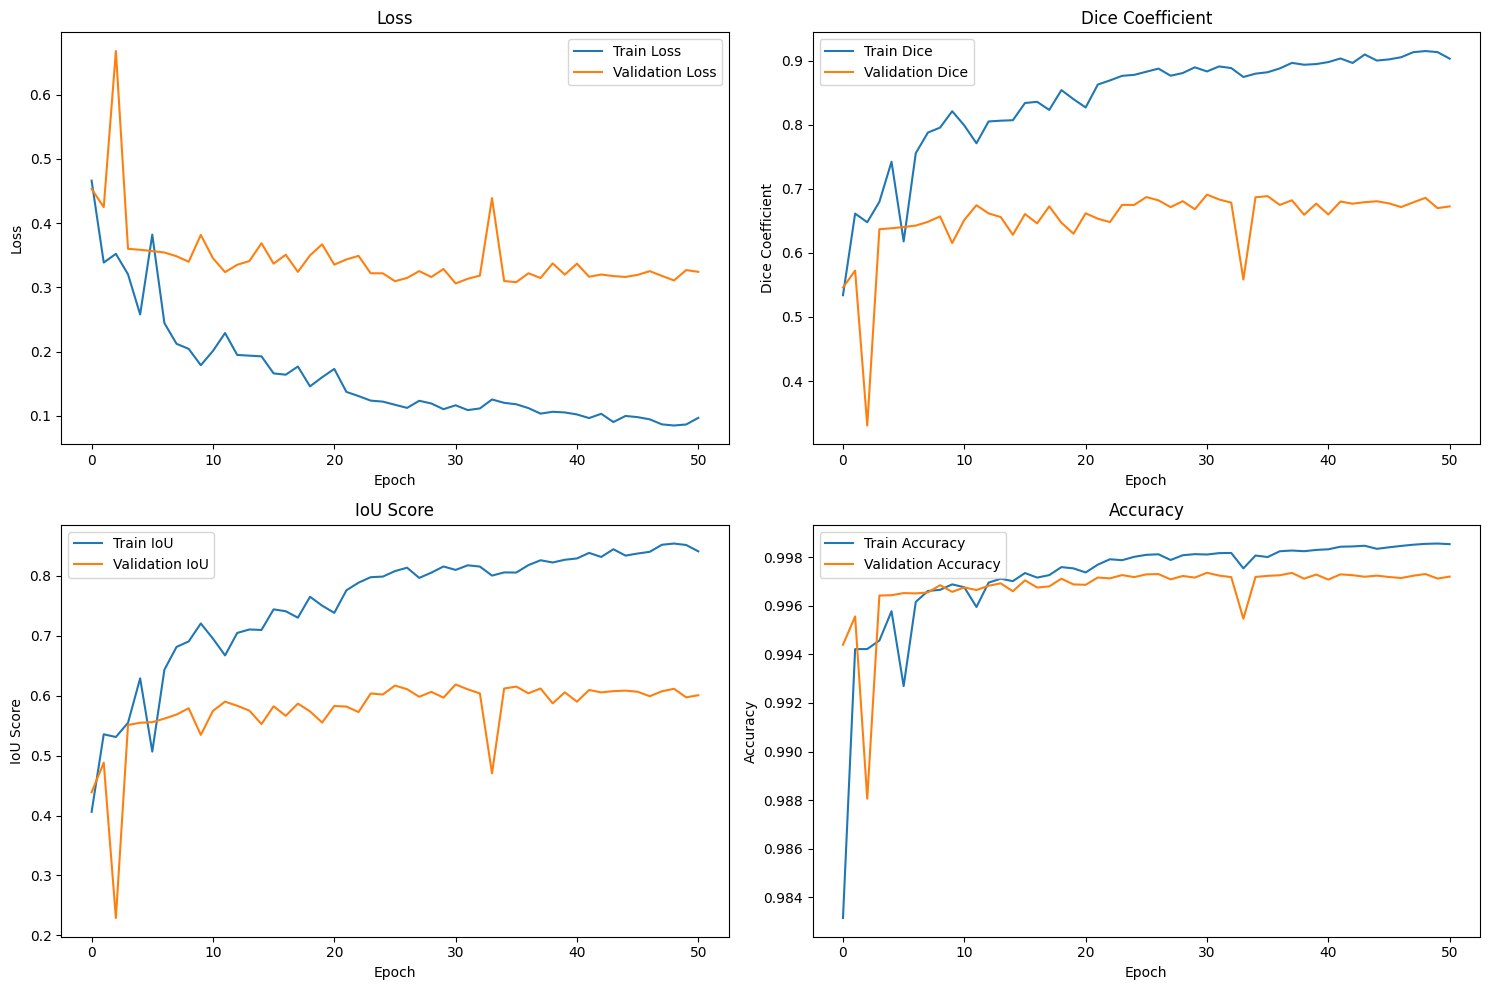

Evaluating model on test data...
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step

E0000 00:00:1748621555.630920      92 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748621555.867769      92 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748621556.677105      92 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748621556.937937      92 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748621557.205526      92 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-30

19/19 ━━━━━━━━━━━━━━━━━━━━ 39s 881ms/step
Test Results:
Dice Coefficient: 0.8068
IoU Score: 0.7754
Accuracy: 0.9950
Visualizing results...


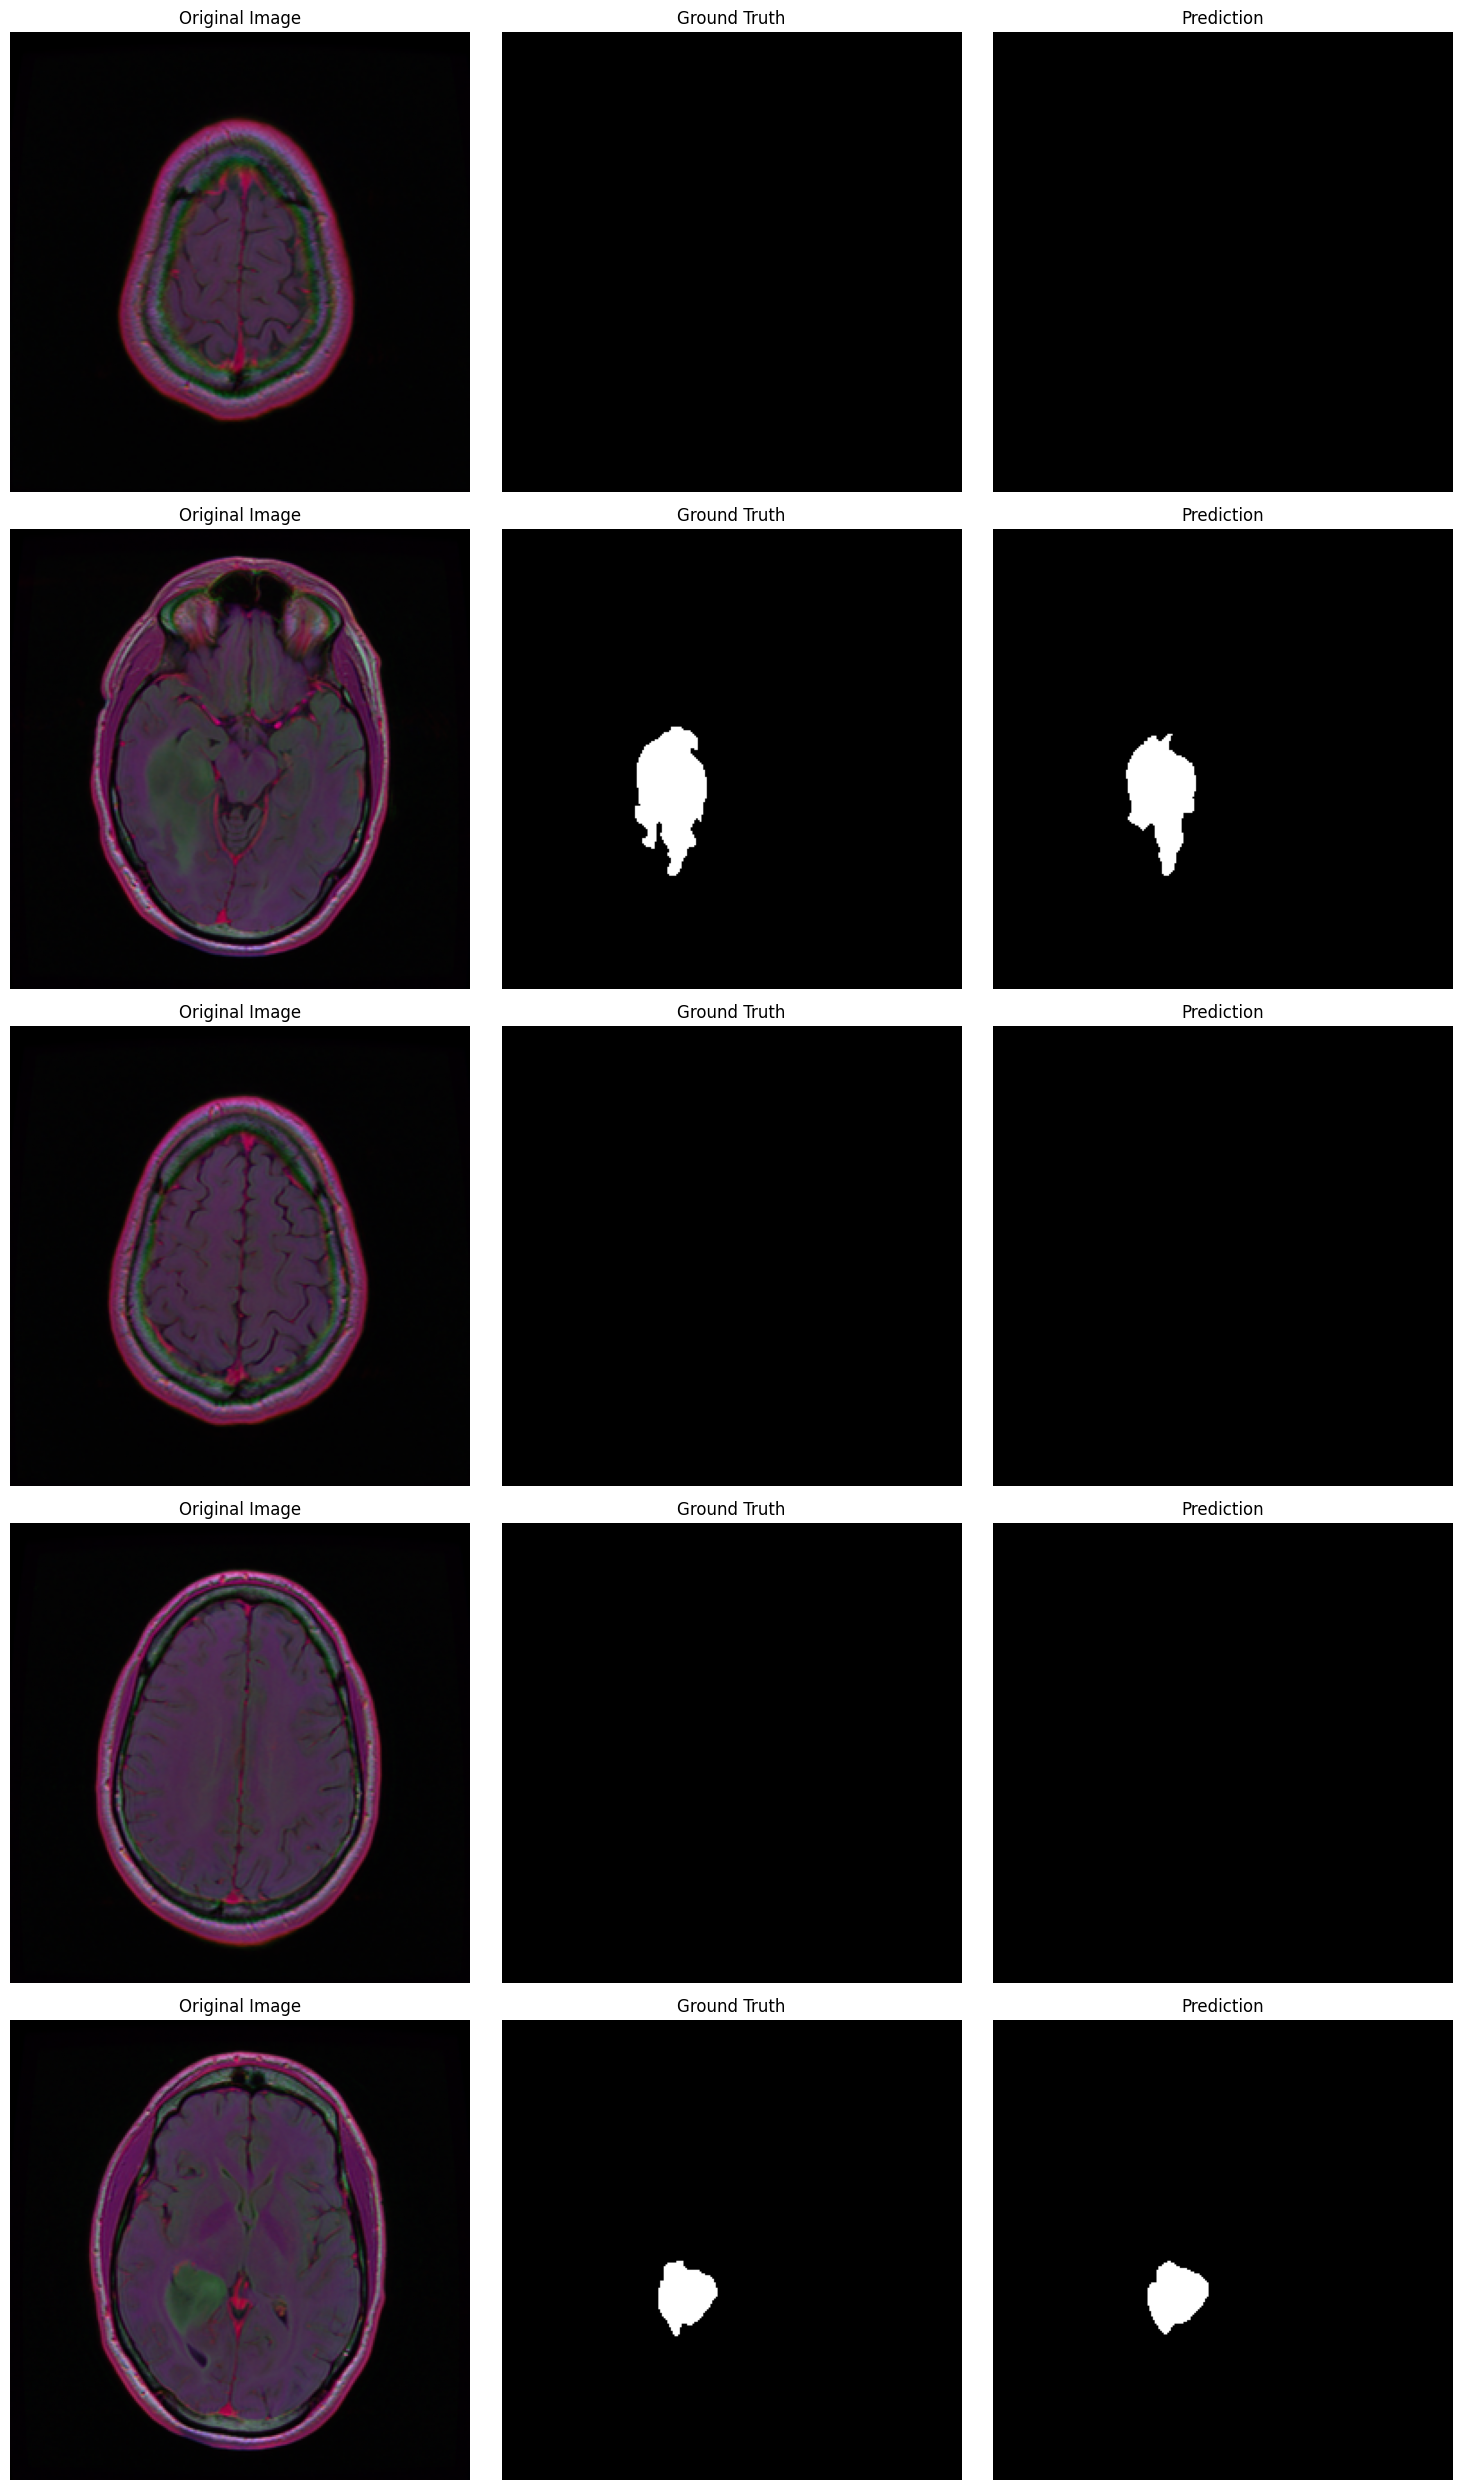

In [7]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Define image size (as per the paper)
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3

# Define metrics (Dice Coefficient and IoU Score)
def dice_coefficient(y_true, y_pred, smooth=1.0):
    """
    Dice Coefficient: 2|X∩Y|/(|X|+|Y|)

    Measures the overlap between the prediction and ground truth.
    - Value 1 indicates perfect overlap
    - Value 0 indicates no overlap
    """
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_coefficient_loss(y_true, y_pred):
    """
    Dice Loss = 1 - Dice Coefficient
    """
    return 1 - dice_coefficient(y_true, y_pred)

def iou_score(y_true, y_pred, smooth=1.0):
    """
    IoU (Intersection over Union) or Jaccard Index: |X∩Y|/|X∪Y|

    Measures the overlap between the prediction and ground truth relative to their union.
    - Value 1 indicates perfect overlap
    - Value 0 indicates no overlap
    """
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# Build UNet-VGG16 model as per the paper
def build_unet_vgg16(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    """
    Build UNet-VGG16 architecture with Transfer Learning as described in the paper
    """
    # Load VGG16 as encoder (contracting path)
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Extract VGG16 layer outputs for skip connections
    # We'll extract from the last convolutional layer of each block
    skip_connections = [
        base_model.get_layer('block1_conv2').output,  # 256x256x64
        base_model.get_layer('block2_conv2').output,  # 128x128x128
        base_model.get_layer('block3_conv3').output,  # 64x64x256
        base_model.get_layer('block4_conv3').output,  # 32x32x512
        base_model.get_layer('block5_conv3').output   # 16x16x512
    ]

    # Freeze the encoder (VGG16 layers) for transfer learning
    for layer in base_model.layers:
        layer.trainable = False

    # Decoder (expanding path)
    # Start from the last skip connection
    x = skip_connections[-1]

    # Upsampling and concatenation for each block
    for i in range(len(skip_connections)-2, -1, -1):
        # Upsampling
        x = Conv2DTranspose(filters=512//(2**(len(skip_connections)-i-2)),
                           kernel_size=(3, 3),
                           strides=(2, 2),
                           padding='same')(x)

        # Concatenate with skip connection
        x = concatenate([x, skip_connections[i]])

        # Two convolutions after each concatenation
        x = Conv2D(filters=512//(2**(len(skip_connections)-i-2)),
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same')(x)
        x = Conv2D(filters=512//(2**(len(skip_connections)-i-2)),
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same')(x)

    # Final convolution layer to get the segmentation map
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=outputs)

    return model

# Data loader function
def load_data(data_dir, img_size=(IMG_HEIGHT, IMG_WIDTH)):
    """Load images and masks from the specified directory"""
    images = []
    masks = []

    for patient_folder in os.listdir(data_dir):
        patient_path = os.path.join(data_dir, patient_folder)
        if os.path.isdir(patient_path):
            for file in os.listdir(patient_path):
                if file.endswith('.tif') and not file.endswith('_mask.tif'):
                    # Image path
                    img_path = os.path.join(patient_path, file)

                    # Corresponding mask path
                    mask_path = img_path.replace('.tif', '_mask.tif')

                    if os.path.exists(mask_path):
                        # Load and preprocess image
                        img = cv2.imread(img_path)
                        if img is None:
                            continue
                        img = cv2.resize(img, img_size)
                        img = img / 255.0  # Normalize

                        # Load and preprocess mask
                        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                        if mask is None:
                            continue
                        mask = cv2.resize(mask, img_size)
                        mask = (mask > 0).astype(np.float32)  # Binary mask
                        mask = np.expand_dims(mask, axis=-1)  # Add channel dimension

                        images.append(img)
                        masks.append(mask)

    return np.array(images), np.array(masks)

# Create data generators
class DataGenerator(tf.keras.utils.Sequence):
    """Data generator for batch processing"""
    def __init__(self, images, masks, batch_size=16, shuffle=True):
        self.images = images
        self.masks = masks
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(images))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_images = [self.images[i] for i in batch_indexes]
        batch_masks = [self.masks[i] for i in batch_indexes]
        return np.array(batch_images), np.array(batch_masks)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

# Function to train the model
def train_model(model, train_gen, val_gen, epochs=100, save_dir='models'):
    """Train the UNet-VGG16 model"""
    os.makedirs(save_dir, exist_ok=True)

    # Create callbacks
    checkpoint = ModelCheckpoint(
        os.path.join(save_dir, 'unet_vgg16_best.keras'),
        monitor='val_dice_coefficient',
        mode='max',
        save_best_only=True,
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_dice_coefficient',
        mode='max',
        patience=20,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_dice_coefficient',
        mode='max',
        factor=0.5,
        patience=10,
        min_lr=1e-7,
        verbose=1
    )

    csv_logger = CSVLogger(os.path.join(save_dir, 'training_log.csv'))

    # Train the model
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=[checkpoint, early_stopping, reduce_lr, csv_logger]
    )

    return history

# Evaluation function
def evaluate_model(model, test_images, test_masks):
    """Evaluate the model on test data"""
    # Predict masks
    pred_masks = model.predict(test_images)

    # Calculate metrics
    dice_scores = []
    iou_scores = []
    accuracy_scores = []

    for i in range(len(test_masks)):
        # Convert predictions to binary using threshold 0.5
        pred_mask = (pred_masks[i] > 0.5).astype(np.float32)
        true_mask = test_masks[i]

        # Flatten the masks
        pred_mask_flat = pred_mask.flatten()
        true_mask_flat = true_mask.flatten()

        # Calculate Dice
        intersection = np.sum(pred_mask_flat * true_mask_flat)
        dice = (2. * intersection + 1.0) / (np.sum(pred_mask_flat) + np.sum(true_mask_flat) + 1.0)
        dice_scores.append(dice)

        # Calculate IoU
        union = np.sum(pred_mask_flat) + np.sum(true_mask_flat) - intersection
        iou = (intersection + 1.0) / (union + 1.0)
        iou_scores.append(iou)

        # Calculate Accuracy
        accuracy = np.mean((pred_mask_flat == true_mask_flat).astype(np.float32))
        accuracy_scores.append(accuracy)

    return {
        'dice_coefficient': np.mean(dice_scores),
        'iou_score': np.mean(iou_scores),
        'accuracy': np.mean(accuracy_scores),
        'pred_masks': pred_masks
    }

# Visualization function
def visualize_results(images, true_masks, pred_masks, num_samples=5):
    """Visualize the segmentation results"""
    plt.figure(figsize=(15, 5*num_samples))

    for i in range(min(num_samples, len(images))):
        # Original image
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')

        # True mask
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(true_masks[i][..., 0], cmap='gray')
        plt.title('Ground Truth')
        plt.axis('off')

        # Predicted mask
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow((pred_masks[i][..., 0] > 0.5).astype(np.float32), cmap='gray')
        plt.title('Prediction')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('segmentation_results.png')
    plt.show()

# Plot training history
def plot_history(history, save_path='training_history.png'):
    """Plot training history metrics"""
    plt.figure(figsize=(15, 10))

    # Plot loss
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Dice Coefficient
    plt.subplot(2, 2, 2)
    plt.plot(history.history['dice_coefficient'], label='Train Dice')
    plt.plot(history.history['val_dice_coefficient'], label='Validation Dice')
    plt.title('Dice Coefficient')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.legend()

    # Plot IoU Score
    plt.subplot(2, 2, 3)
    plt.plot(history.history['iou_score'], label='Train IoU')
    plt.plot(history.history['val_iou_score'], label='Validation IoU')
    plt.title('IoU Score')
    plt.xlabel('Epoch')
    plt.ylabel('IoU Score')
    plt.legend()

    # Plot Accuracy
    plt.subplot(2, 2, 4)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

# Main function to run the workflow
def main():
    # Load data
    print("Loading training data...")
    train_images, train_masks = load_data(adapt_path("Brain MRI Split/train_augmented"))

    print("Loading validation data...")
    val_images, val_masks = load_data("Brain MRI Split/val")

    print("Loading test data...")
    test_images, test_masks = load_data("Brain MRI Split/test")

    print(f"Training samples: {len(train_images)}")
    print(f"Validation samples: {len(val_images)}")
    print(f"Test samples: {len(test_images)}")

    # Create data generators
    batch_size = 8
    train_gen = DataGenerator(train_images, train_masks, batch_size=batch_size)
    val_gen = DataGenerator(val_images, val_masks, batch_size=batch_size, shuffle=False)

    # Build model
    print("Building UNet-VGG16 model...")
    model = build_unet_vgg16()

    # Compile model with Dice Loss and Adam optimizer
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss=dice_coefficient_loss,
        metrics=[dice_coefficient, iou_score, 'accuracy']
    )

    # Model summary
    model.summary()

    # Train model
    print("Training model...")
    history = train_model(model, train_gen, val_gen, epochs=100)

    # Plot training history
    plot_history(history)

    # Evaluate model on test data
    print("Evaluating model on test data...")
    results = evaluate_model(model, test_images, test_masks)

    print("Test Results:")
    print(f"Dice Coefficient: {results['dice_coefficient']:.4f}")
    print(f"IoU Score: {results['iou_score']:.4f}")
    print(f"Accuracy: {results['accuracy']:.4f}")

    # Visualize results
    print("Visualizing results...")
    visualize_results(test_images, test_masks, results['pred_masks'])

    return model, history, results

if __name__ == "__main__":
    main()